## Notebook to model Gij using gene expression programming

In [1]:
#  Import libraries
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import os
import time
import geppy as gep
import operator
from deap import tools, creator, base 
import random
import sympy as sp
from sklearn.linear_model import LinearRegression as LR
import pickle
import glob
import math


The module graphviz is not available, on which geepy.export_expression_tree depends.
                The geepy.graph function will not be visible until this module is installed. 
                To install graphviz, please check https://pypi.org/project/graphviz/.


In [2]:
# Read the relevant data
# Tij = Reynolds stress
# Lij = inverse of Reynolds stress
# rho = density
# mv = mean velocity
# meanVelGrad = mean velocity gradient


#################################################################################
#Note here that Gij is actually <a_iu_j>
# The reason to do this is it is easier to model <a_iu_j> than Gij
# Gij_p = <a_iu_j>*Lij
#################################################################################
def read_data(loc,d,delU,steps=0):
    Gij = np.loadtxt(loc+'/accu_'+d+'.dat')
    Tij = np.loadtxt(loc+'/Tij_'+d+'.dat')
    K   = np.loadtxt(loc+'/k-eps_'+d+'.dat')    
    meanVelGrad = np.loadtxt(loc+'/mean_vel_grad_'+d+'.dat')
    Lij = np.loadtxt(loc+'/lambda_'+d+'.dat')
    Reyn = np.loadtxt(loc+'/Reyn_'+d+'.dat')
    rho = np.loadtxt(loc+'/rho_'+d+'.dat')
    mv = np.loadtxt(loc+'/mean_vel_'+d+'.dat')
    
    
    # Momentum thickness
    delta = np.ones(Reyn.shape[0])*np.sum(rho*(delU/2-mv[:,0])*(delU/2+mv[:,0]))*7.34e-6/(0.68*delU**2)
    x = np.linspace(0,0.0423,576)
    x = x-0.0423/2.0
    eps = np.copy(K[:,1])
    K   = K[:,0]
    index = np.where(K>0.05*np.max(K))
    t_time = np.zeros(576)
    t_time[:] = int(d)*3.38e-7
    
    loend = index[0][0]
    hiend = index[0][-1]
    if(steps):
        
        Gij = Gij[0:-1:steps,:]
        Lij = Lij[0:-1:steps,:]
        Tij = Tij[0:-1:steps,:]
        meanVelGrad = meanVelGrad[0:-1:steps,:]
        K = K[0:-1:steps]
        eps = eps[0:-1:steps]
        delta = delta[0:-1:steps]
        rho = rho[0:-1:steps]
    
    K = abs(K)
    eps = abs(eps)
    

    
    return Gij, Tij, meanVelGrad, eps, K, Lij, Reyn, delta,x,t_time

    

    

In [3]:
# Read data for a timestep and transform to relevant quantities

def get_training_data_time(dir_loc,time,normalise=False,normalise_const=True,delU=100,steps=0):

    files = sorted(glob.glob(dir_loc+'accu*.dat'))
    indexes = [F[-7:-4] for F in files]        
    loindices = np.zeros(len(indexes)+1)
    Gij, Tij , meanVelGrad , eps, K, Lij, Reyn, delta, x, t_time = read_data(dir_loc,indexes[time],delU,steps)

    loindices[1] = K.shape[0]
    
    b = np.copy(Tij)
    b[:,0] = b[:,0]-2.0*K/3.0
    b[:,4] = b[:,4]-2.0*K/3.0
    b[:,8] = b[:,8]-2.0*K/3.0
    Gij = np.reshape(Gij,(Gij.shape[0],3,3))
    Tij = np.reshape(Tij,(Tij.shape[0],3,3))
    meanVelGrad = np.reshape(meanVelGrad,(meanVelGrad.shape[0],3,3))
    b = np.reshape(b,(b.shape[0],3,3))
    Lij = np.reshape(Lij,(Lij.shape[0],3,3))
    

    Sij = np.zeros((b.shape[0],3,3))
    omega = np.zeros((b.shape[0],3,3))
    
    for i in range(Sij.shape[0]):
        Sij[i,:,:] = 0.5*(meanVelGrad[i,:,:]+np.transpose(meanVelGrad[i,:,:]))
        omega[i,:,:] = 0.5*(meanVelGrad[i,:,:]-np.transpose(meanVelGrad[i,:,:]))
        
    b = b/(2.0*K[:,None,None])
    
    Dim_2D=0
    if(Dim_2D):
        Gij = Gij[:,0:2,0:2]
        Tij = Tij[:,0:2,0:2]
        b = b[:,0:2,0:2]
        meanVelGrad = meanVelGrad[:,0:2,0:2]
        Lij = Lij[:,0:2,0:2]
        Sij = Sij[:,0:2,0:2]
        omega = omega[:,0:2,0:2]
        
    
    if(normalise):    
        Gij = Gij/(eps[:,None,None])
        Tij = Tij/K[:,None,None]
        meanVelGrad = (meanVelGrad*K[:,None,None])/eps[:,None,None]
        
        Sij = Sij*K[:,None,None]/eps[:,None,None]
        omega = omega*K[:,None,None]/eps[:,None,None]
        Lij = Lij*K[:,None,None]
    
    
    if(normalise_const):
        
        Gij = Gij*delta[0]/delU**3        
        Tij = Tij/delU**2
        meanVelGrad = meanVelGrad*delta[0]/delU
        Sij = Sij*delta[0]/delU
        omega = omega*delta[0]/delU
        eps = eps*delta[0]/delU**3
        K = K/delU**2
        Lij = Lij*delU**2
        t_time = t_time*delU/delta[0]
        
    return Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K, Reyn, delta


In [4]:
# Read and accumulate data
# Data can be read in steps, instead of reading all data read in steps of "step"
def get_training(direc,ist,nt,stp, delU,i1,j1, norm1,norm2,steps):
            Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K, Reyn, delta = get_training_data_time(direc,ist,norm1,norm2,delU,steps)
            for i in range(ist+stp,nt,stp):
                Gij1, Tij1, meanVelGrad1, b1, Sij1, omega1, Lij1, eps1, K1, Reyn1, delta1 = get_training_data_time(direc,i,norm1,norm2,delU,steps)
                Gij = np.append(Gij,Gij1,axis=0)
                Tij = np.append(Tij,Tij1,axis=0)
                meanVelGrad = np.append(meanVelGrad,meanVelGrad1,axis=0)
                b = np.append(b,b1,axis=0)
                Sij = np.append(Sij,Sij1,axis=0)
                omega = np.append(omega,omega1,axis=0)
                Lij = np.append(Lij,Lij1,axis=0)
                eps = np.append(eps,eps1,axis=0)
                K = np.append(K,K1,axis=0)
                delta = np.append(delta,delta1,axis=0)                
                Reyn = np.append(Reyn,Reyn1,axis=0)
                
            return Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K , Reyn, delta

In [5]:
# Wrapper to get data
def get_data(dirs,ist,st,nstp,delU,steps, norm=False, norm_const=False):
    Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K , Reyn, delta = get_training(dirs,ist,st,nstp,delU,0,0,norm,norm_const,steps)
    mvgT = np.transpose(meanVelGrad,(0,2,1))
    I = np.ones((Gij.shape[0],3,3))
    I[None,:,:] = np.identity(3)
    return Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K , Reyn, I, mvgT, delta


In [6]:
# Get data
delU = 100
Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K , Reyn, I, mvgT,delta = get_data('./data/data_50/',0,118,1,delU,4, norm=True, norm_const=False)



In [7]:
# Function set for Genes
# This work only uses addition, subtraction and multiplication
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

def protected_exp(x1):
    if abs(x1) > 2:
        return 1
    return np.exp(x1)

def protected_log(x1):
    if x1 <= 1:
        return 1
    return np.log(x1)
exp = np.vectorize(protected_exp)
log = np.vectorize(protected_log)

def mult_three(*args):    
    out=1
    for i in range(len(args)):
        out = out*args[i]      
    return out

def add_three(*args):    
    out=0
    for i in range(len(args)):
        out = out+args[i]      
    return out

def matmul(x1,x2):    
    if(np.isscalar(x1) or np.isscalar(x2)):
        
        return x1*x2
    if(x1.shape[1]==1 or x2.shape[1]==1):
        return x1*x2
    
    
    return np.matmul(x1,x2)

def transpose(x1):
    
    if(np.isscalar(x1)):
        return x1
        
    return np.transpose(x1)
    

def trace(x1):
    
    if(np.isscalar(x1)):
        return x1
    return np.trace(x1)

def matdot(x1,x2):    
    if(np.isscalar(x1) or np.isscalar(x2)):
        return x1*x2
    
    if(x1.shape[1]==1 or x2.shape[1]==1):
        return np.sum(x1*x2)
    
    return np.sum(x1*x2)

def matdot2(x1,x2):    
    
    
    return x1*x2



In [8]:
# Functions and inputs for the main gene
pset = gep.PrimitiveSet('main', input_names=['b','mvg','mvgT','I'])
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(matmul, 2)
pset.add_rnc_terminal()

# Functions and inputs for the plasmid
#pset.add_plasmid_terminal()
pset2 = gep.PrimitiveSet('main2', input_names=['T_b','T_mvg','T_mvgT','T_I'])
#pset2.add_rnc_terminal()
pset2.add_function(operator.add, 2)
pset2.add_function(operator.sub, 2)
pset2.add_function(matmul, 2)
#pset2.add_function(transpose, 1)
#pset2.add_function(trace, 1)


 


In [9]:
# Create relevant objects
creator.create("FitnessMin", base.Fitness, weights=(-1,))
creator.create('Individual', gep.Chromosome, fitness=creator.FitnessMin)

# Define algorithm parameters
h = 3 # head length
n_genes = 4
toolbox = gep.Toolbox()
r=10
toolbox.register('rnc_gen', random.uniform, a=-1, b=1)   # each RNC is random integer within [-1, 1]
toolbox.register('gene_gen', gep.GenePlasmid, pset=pset, head_length=h,rnc_gen=toolbox.rnc_gen, rnc_array_length=r,pset_plasmid=pset2,head_plasmid=3,n_plasmid=1)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=add_three)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)



In [10]:
# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_plasmids, pset=pset, pset_plasmid=pset2)

In [11]:
# A function which gives a score to each individual in the population
# This implementation considers the whole tensor
# Also fits linear regression to the GEP output and stores the slope parameter
# Details in paper draft
def evaluate_linear_scaling_tensor(individual, Npts=144):
    # Npts is the number of points in one time instant data
    # Although the number of points in DNS is 576, for fitting I sample 1/4 th points because training is faster
    """Evaluate the fitness of an individual with linearly scaled MSE.
    Get a and b by minimizing (a*Yp + b - Y)"""
    func = toolbox.compile(individual)
    predict = np.array(list(map(func,b, meanVelGrad,mvgT,I,b, meanVelGrad,mvgT,I)))  
    
    
    if(predict.ndim==1):
        slp = np.ones((3,3))
        individual.a = slp
        predict = predict*eps
        G = Gij*eps[:,None,None]
        
        G = np.reshape(G,[Npts,int(G.shape[0]/Npts),3,3])
        predict = np.reshape(predict,[Npts,int(predict.shape[0]/Npts)])
        err = np.sqrt(np.mean(((G-predict[:,:,None,None]))**2,axis=0)/np.mean((G)**2,axis=0))
        return np.mean(err),
        

    resid = np.zeros(Gij.shape[0])
    slp = np.zeros((3,3))
    for i in range(0,3):
        for j in range(0,3):            
                         
                Yp = predict[:,i,j]
                model = LR(fit_intercept=False)
                model.fit((Yp*eps).reshape(-1,1),(Gij[:,i,j]*eps).reshape(-1,1))
                slp[i,j] = model.coef_
                
                
    predict = predict*eps[:,None,None]*slp[None,:,:]
    individual.a = slp
    
    G = Gij*eps[:,None,None]
    
    G = np.reshape(G,[Npts,int(G.shape[0]/Npts),3,3])
    predict = np.reshape(predict,[Npts,int(predict.shape[0]/Npts),3,3])
    
    err = np.sqrt(np.mean(((G-predict))**2,axis=0)/np.mean((G)**2,axis=0))
    err[:,1,2]=0
    err[:,0,2]=0
    err[:,2,[0,1]]=0
    
    return np.mean(err),   

        

In [12]:
# Define the evaluation function and tournament type, size
toolbox.register('evaluate', evaluate_linear_scaling_tensor)
toolbox.register('select', tools.selTournament, tournsize=4)

In [13]:
# Define type of genetic operations, along with their probabilities
# Some of these are native functions of geppy, others I have implemented
toolbox.register('mut_uniform', gep.mutate_uniform_gene_plasmid, pset=pset,pset_plasmid=pset2, ind_pb=1,pb=0.8)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.2)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.1)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)

# 2. Dc-specific operators
toolbox.register('mut_dc', gep.mutate_uniform_dc, ind_pb=0.1, pb=0.3)
toolbox.register('mut_invert_dc', gep.invert_dc, pb=0.1)

# This doesn't work with plasmid right now
#toolbox.register('mut_transpose_dc', gep.transpose_dc, pb=0.1)

# for some uniform mutations, we can also assign the ind_pb a string to indicate our expected number of point mutations in an individual
toolbox.register('mut_rnc_array_dc', gep.mutate_rnc_array_dc, rnc_gen=toolbox.rnc_gen, ind_pb='0.2p',pb=0.3)


In [14]:
# Save stats for mean, min and median
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("median", np.median)


In [15]:
# Define size of population and number of generations
# Start the fitting process
# See the function definition for details about the input parameters
# Custom implementation of hill climbing algorithm
bests = []
loss = []
n_pop = 10
n_gen = 10
champs = 5
for i in range(0,1):
    pop = toolbox.population(n=n_pop) # 
    hof = tools.HallOfFame(champs)   # only record the best three individuals ever found in all generations
    pop, log = gep.gep_simple(pop, toolbox, do_hill=True, niter=10,nmut=2,nfreq=2, pop_frac=0.3, n_generations=n_gen, n_elites=1,
                           stats=stats,hall_of_fame=hof, verbose=True)
    bests.append(hof[0])
    loss.append(log[n_gen-1]['min'])
    print(i)


gen	nevals	avg     	min     	median 
0  	10    	0.287979	0.254629	0.29064
1  	7     	0.27851 	0.254629	0.267901
2  	9     	0.271399	0.254623	0.2613  
3  	4     	0.254401	0.244728	0.254612
4  	8     	0.261395	0.244728	0.254581
5  	6     	0.251992	0.244728	0.254456
6  	9     	0.254394	0.244728	0.250622
7  	5     	0.258371	0.244628	0.244826
8  	9     	0.269797	0.244628	0.253941
9  	5     	0.250072	0.244628	0.244728
10 	9     	0.247509	0.222629	0.244652
0


## Now that we have a solution, we can make predictions
## Best solution stored in bests list

In [46]:
# Returns the predictions of a chromosone, DNS values along with erros in the predictions

def get_error_Gij(chrom, Gij, b, meanVelGrad, mvgT, I, eps, K, Npts=144):
    f= toolbox.compile(chrom)
    predict = np.array(list(map(f, b,meanVelGrad,mvgT,I,b, meanVelGrad, mvgT, I)))  
    
    predict = predict*eps[:,None,None]*chrom.a[None,:,:] 
        
    G = np.copy(Gij)
    G = G*eps[:,None,None]
    
    errs = np.zeros((int(G.shape[0]/Npts),3,3))
    for i in range(0,errs.shape[0]):
        errs[i,:,:] = np.sqrt(np.mean((G[i*Npts:(i+1)*Npts,:,:]-predict[i*Npts:(i+1)*Npts,:,:])**2,axis=0)/np.mean(G[i*Npts:(i+1)*Npts,:,:]**2,axis=0))
    return errs, predict, G
    

In [47]:
# Get predictions
Gij, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K , Reyn, I, mvgT,delta = get_data('./data/data_50/',0,118,1,delU,0, norm=True, norm_const=False)
errs, predict, G = get_error_Gij(hof[0], Gij, b, meanVelGrad, mvgT, I, eps, K )
# RSS_DNS is the value of the unclosed terms in the Reynolds stress transport equation
# RSS_GEP is the value of the unclosed terms in the Reynolds stress transport equation predicted by GEP

RSS_DNS = G + np.transpose(G,(0,2,1))
RSS_GEP = predict + np.transpose(predict,(0,2,1))


In [48]:
# Function to compute error in the predictions of GEP 
def get_error_tot(DNS,pred):
    Npts=576
    err = np.zeros(int(DNS.shape[0]/Npts))
    for k in range(0,err.shape[0]):
        err[k] = np.sqrt(np.mean((DNS[k*Npts:(k+1)*Npts,:,:]-pred[k*Npts:(k+1)*Npts,:,:])**2)/np.mean(DNS[k*Npts:(k+1)*Npts,:,:]**2))
    return err

In [49]:
# Function to compute Reynolds stress closure implied by values of Gij
# Can be used with any model, e.g. SLM, LIPM etc
# See equation 10 in the paper draft, need to supply Gij_p instead of Gij
def get_RSM(Gij,Tij):
    RSM = np.zeros((Gij.shape[0],3,3))
  
    for i in range(0,3):
        for j in range(0,3):
            for k in range(0,3):
                RSM[:,i,j]=RSM[:,i,j]+Gij[:,i,k]*Tij[:,k,j]+Gij[:,j,k]*Tij[:,k,i]
    return RSM

In [50]:
# Function to get data needed for getting Gij for various models like SLM, LIPM etc
def get_data_RSS(direc,ist,nt,stp, delU):
            _, Tij, meanVelGrad, b, Sij, omega, Lij, eps, K, _, _,  = get_training_data_time(direc,ist,False,False,delU)
            for i in range(ist+stp,ist+nt,stp):
                _, Tij1, meanVelGrad1, b1, Sij1, _, Lij1, eps1, K1, _, _, = get_training_data_time(direc,i,False,False,delU)
                Tij = np.append(Tij, Tij1, axis=0)
                b = np.append(b, b1, axis=0)                
                meanVelGrad = np.append(meanVelGrad,meanVelGrad1,axis=0)
                Sij = np.append(Sij,Sij1,axis=0)
                Lij = np.append(Lij,Lij1,axis=0)
                eps = np.append(eps,eps1,axis=0)
                K = np.append(K,K1,axis=0)
            
                
            return Tij, b, meanVelGrad, Sij,omega, Lij, eps, K

In [51]:
# LIPM model for Gij, this will return Gij_p instead of Gij, for difference see the paper draft
def LIPM_model(C0,CIPM,alpha2,alpha3,beta1,beta2,beta3,gama5,gama6,b,Tij,meanVelGrad,eps,K,lambdaij,Sij):
    pred = np.zeros((K.shape[0],3,3))
    for i in range(0,K.shape[0]):        
        #P = - 0.5*np.trace(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i])) + np.transpose(np.matmul(Tij[:,:,i],np.transpose(meanVelGrad[:,:,i]))))
        #To be used when normalised by eps/K 
        P1 = b[i,:,:]*Sij[i,:,:]
        P = -2.0*P1.sum()*K[i]
        B3 = np.matmul(np.matmul(b[i,:,:],b[i,:,:]),b[i,:,:])
        
        alpha1 = -(0.5+3.0/4*C0)+3.0*alpha2*np.trace(B3)+0.5*CIPM*P/eps[i] #P is non dim so no omega here
        
        pred[i,:,:] = (alpha1*np.eye(3,3)+alpha2*b[i,:,:] + alpha3*np.matmul(b[i,:,:],b[i,:,:]))*eps[i]/K[i] + beta1*np.eye(3,3)*np.trace(meanVelGrad[i,:,:]) + \
        beta2*meanVelGrad[i,:,:] + beta3*np.transpose(meanVelGrad[i,:,:]) + gama5*np.matmul(b[i,:,:],meanVelGrad[i,:,:]) + \
        gama6*np.matmul(b[i,:,:],np.transpose(meanVelGrad[i,:,:]))
     
        pred[i,:,:] = pred[i,:,:]+0.5*C0*eps[i]*lambdaij[i,:,:]
       
    return pred

    

In [52]:
# SLM model
def get_SLM(C0,eps,K,Lij):
        pred = np.zeros((K.shape[0],3,3))
    
        for i in range(0,K.shape[0]):
            pred[i,:,:] = -(0.5+3.0/4*C0)*np.eye(3,3)*eps[i]/K[i] + 0.5*C0*eps[i]*Lij[i,:,:]
    
        return pred

In [53]:
# Get Reynolds stress closure for SLM and LIPM model

Tij2, b2, meanVelGrad2, Sij2, omega2, Lij2, eps2, K2 = get_data_RSS('./data/data_50/',0,118,1,100)
#Tij2, b2, meanVelGrad2, Sij2, omega2, Lij2, eps2, K2 = get_data_RSS('./GEP/data_75/data/',0,137,1,100)


LIPM  = LIPM_model(2.1,0.6,3.5,-3*3.5,-0.2,0.8,-0.2,0.6,-0.6,b2,Tij2,meanVelGrad2,eps2,K2,Lij2,Sij2)
SLM  =  get_SLM(2.1,eps2,K2,Lij2)

RSS_LIPM = get_RSM(LIPM,Tij2)
RSS_SLM = get_RSM(SLM,Tij2)


In [54]:
# Errors in the prediction of Reynolds stress closure by various models
err = get_error_tot(RSS_DNS,RSS_LIPM)
err2 = get_error_tot(RSS_DNS,RSS_GEP)
err3 = get_error_tot(RSS_DNS,RSS_SLM)


<IPython.core.display.Javascript object>


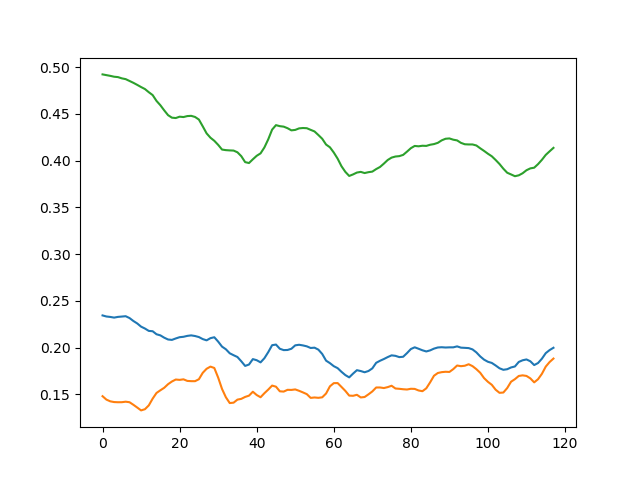

In [41]:
plt.figure()
plt.plot(err)
plt.plot(err2)
plt.plot(err3)

In [55]:
#Function to get normalised time values for the data used in this study, will be used to plot figure
def get_delta_t(dir_loc,ist,nt,stp,delU):
    files = sorted(glob.glob(dir_loc+'accu*.dat'))
    indexes = [F[-7:-4] for F in files]        
    tnorm = []
    for i in range(ist,nt,stp):    
        d = indexes[i]
        rho = np.loadtxt(dir_loc+'/rho_'+d+'.dat')
        mv = np.loadtxt(dir_loc+'/mean_vel_'+d+'.dat')
        dely = 0.423e-2/576
        delta = np.sum(rho*(delU/2-mv[:,0])*(delU/2+mv[:,0]))*dely/(rho[0]*delU**2)
        tnorm.append(int(d)*3.38064e-7*delU/0.0109e-3)
        #tnorm.append(delta)
    return np.array(tnorm)

In [56]:
tnorm = get_delta_t('./data/data_50/',0,118,1,100)
#tnorm = get_delta_t('./GEP/data_75/data/',0,137,1,100)


<IPython.core.display.Javascript object>


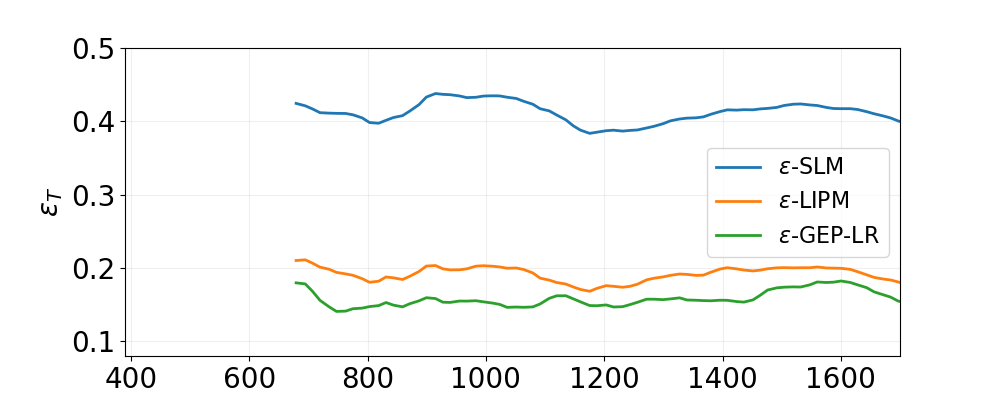

In [44]:
# Code for figures 5 and 6
plt.figure(figsize=(10,4))
ax=plt.gca()
plt.ylim(0.08,0.5)
plt.yticks([0.1, 0.2,0.3,0.4,0.5])
plt.xlim(390,1700)
plt.xticks([400,600,800,1000,1200,1400,1600])
ind=28
#l1=ax.plot(tnorm[:100],err3[:100],'-C0',linewidth=2,markersize=6,markeredgewidth=2,label='$\\epsilon$-SLM')
#l2=ax.plot(tnorm[:100],err[:100],'-C1',linewidth=2,markersize=6,markeredgewidth=2,label='$\\epsilon$-LIPM')
#l3=ax.plot(tnorm[:100],err2[:100],'-C2',linewidth=2,markersize=6,markeredgewidth=2,label='$\\epsilon$-GEP-LR')
l1=ax.plot(tnorm[ind:],err3[ind:],'-C0',linewidth=2,markersize=6,markeredgewidth=2,label='$\\epsilon$-SLM')
l2=ax.plot(tnorm[ind:],err[ind:],'-C1',linewidth=2,markersize=6,markeredgewidth=2,label='$\\epsilon$-LIPM')
l3=ax.plot(tnorm[ind:],err2[ind:],'-C2',linewidth=2,markersize=6,markeredgewidth=2,label='$\\epsilon$-GEP-LR')


#plt.xlim(400,1600)
plt.ylabel('$\\epsilon_T$')
plt.xlabel('$t\\Delta U/\delta_{\\theta,0}$')
plt.grid(alpha=0.2)
lns = l1+l2+l3
labs = [l.get_label() for l in lns]
ax.legend(lns, labs,loc=0,prop={'size': 16} )
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
            ax.get_xticklabels() + ax.get_yticklabels()):
       item.set_fontsize(20)
#plt.savefig('err-tot-75.png',dpi=300,bbox_inches = "tight")
#plt.close()
    

<IPython.core.display.Javascript object>


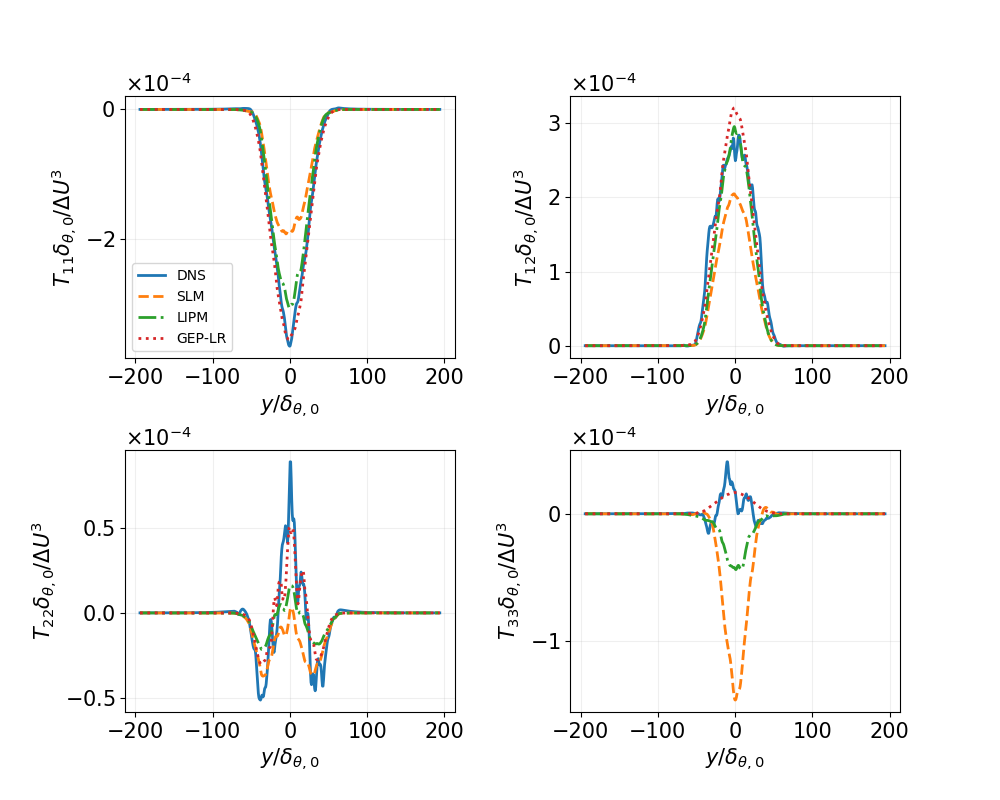

In [57]:
        # Code for figures 3 and 4
        plt.figure(figsize=(10,8))
        x = np.linspace(0,0.423e-2,576)
        x=x-0.423e-2/2
        x=x/0.0109e-3
        plt.subplot(2,2,1) 
        i=15  # 50
        delt = 0.0109e-3
        #i = 40
        plt.plot(x,RSS_DNS[i*576:(i+1)*576,0,0]*delt/delU**3,linewidth=2)        
        plt.plot(x,RSS_SLM[i*576:(i+1)*576,0,0]*delt/delU**3,'--',linewidth=2)
        plt.plot(x,RSS_LIPM[i*576:(i+1)*576,0,0]*delt/delU**3,'-.',linewidth=2)
        plt.plot(x,RSS_GEP[i*576:(i+1)*576,0,0]*delt/delU**3,':',linewidth=2)
        plt.legend(('DNS','SLM','LIPM','GEP-LR'))
        plt.grid(alpha=0.2)
        ax=plt.gca()
        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,6),useMathText=True)

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(15)
        plt.xlabel(r'$y/\delta_{\theta,0}$')
        plt.ylabel(r'$T_{11}\delta_{\theta,0}/\Delta U^3$')
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=8)
        
        ax.yaxis.offsetText.set_fontsize(15)

        plt.subplot(2,2,2) 
        plt.plot(x,RSS_DNS[i*576:(i+1)*576,0,1]*delt/delU**3,linewidth=2)        
        plt.plot(x,RSS_SLM[i*576:(i+1)*576,0,1]*delt/delU**3,'--',linewidth=2)
        plt.plot(x,RSS_LIPM[i*576:(i+1)*576,0,1]*delt/delU**3,'-.',linewidth=2)
        plt.plot(x,RSS_GEP[i*576:(i+1)*576,0,1]*delt/delU**3,':',linewidth=2)
        plt.grid(alpha=0.2)
        ax=plt.gca()
        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,6),useMathText=True)

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(15)
        
        plt.xlabel(r'$y/\delta_{\theta,0}$')
        plt.ylabel(r'$T_{12}\delta_{\theta,0}/\Delta U^3$')
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=8)
        ax.yaxis.offsetText.set_fontsize(15)




        plt.subplot(2,2,3) 
        plt.plot(x,RSS_DNS[i*576:(i+1)*576,1,1]*delt/delU**3,linewidth=2)        
        plt.plot(x,RSS_SLM[i*576:(i+1)*576,1,1]*delt/delU**3,'--',linewidth=2)
        plt.plot(x,RSS_LIPM[i*576:(i+1)*576,1,1]*delt/delU**3,'-.',linewidth=2)
        plt.plot(x,RSS_GEP[i*576:(i+1)*576,1,1]*delt/delU**3,':',linewidth=2)
        plt.grid(alpha=0.2)
        ax=plt.gca()        
        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,6),useMathText=True)
        plt.xlabel(r'$y/\delta_{\theta,0}$')
        plt.ylabel(r'$T_{22}\delta_{\theta,0}/\Delta U^3$')
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=8)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(15)
        ax.yaxis.offsetText.set_fontsize(15)

        
        plt.subplot(2,2,4) 
        plt.plot(x,RSS_DNS[i*576:(i+1)*576,2,2]*delt/delU**3,linewidth=2)        
        plt.plot(x,RSS_SLM[i*576:(i+1)*576,2,2]*delt/delU**3,'--',linewidth=2)
        plt.plot(x,RSS_LIPM[i*576:(i+1)*576,2,2]*delt/delU**3,'-.',linewidth=2)
        plt.plot(x,RSS_GEP[i*576:(i+1)*576,2,2]*delt/delU**3,':',linewidth=2)
        plt.grid(alpha=0.2)
        ax=plt.gca()        
        ax.ticklabel_format(axis='y',style='sci',scilimits=(0,6),useMathText=True)
        plt.xlabel(r'$y/\delta_{\theta,0}$')
        plt.ylabel(r'$T_{33}\delta_{\theta,0}/\Delta U^3$')
        plt.locator_params(axis='y', nbins=4)
        plt.locator_params(axis='x', nbins=8)
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                ax.get_xticklabels() + ax.get_yticklabels()):
                item.set_fontsize(15)
        ax.yaxis.offsetText.set_fontsize(15)

        plt.subplots_adjust(wspace=0.35)
        plt.subplots_adjust(hspace=0.35)
        #plt.xlabel(r'$Y/\\delta_{\\theta}$')
     
           
        #plt.savefig('tij-50.png',dpi=300,bbox_inches = "tight") 
        #plt.close()
    